# Convert MTSSim spectra values to equivalent spectral irradiance Lsky
This notebook is used to simulate spectra at the MIRI input plane given a set of MTSSim input parameters.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
import glob
from astropy.io import fits

import warnings
warnings.simplefilter('ignore')

In [2]:
# set directories
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
pyMTSDir = workDir+'notebooks/pyMTSSim/OUTPUT/'

In [3]:
# load simulated spectra
files = glob.glob(pyMTSDir+'MTS*'+'K_spec.fits')

Vdata = {}
for ifile in files:
    BB_Temp = ifile.split('OUTPUT/MTS')[1].split('K_spec')[0]
    Vdata[BB_Temp+'K'] = fits.open(ifile)[1].data['SPC']

In [4]:
# Create a dictionary to hold wavelengths and equivalent spectral irradiance
waves = {}
L_skys = {}

for ifile in files:
    BB_Temp = ifile.split('OUTPUT/MTS')[1].split('K_spec')[0]
    
    hdulist = fits.open(ifile)
    wave = hdulist[1].data["wave"]
    S_mts = hdulist[1].data["SPC"]
    hdulist.close()
    
    # IMTS = S_mts / (p_arc/p_m) 2  	[Jy m2 arcsec-2 = 10-26 W Hz-1 arcsec-2]
    # where p_m [meter] is the projected linear size of a MIRI pixel in the MIRI 
    # input plane and p_arc the corresponding angle subtended by the pixel on the sky. 
    # We can take this scaling from the MIRI imager, with pixel pitch 0.11 arcsec, 
    # 1024 pixels in the FPA array, and the projected size of the imager FPA in the 
    # input plane 72mm.  
    # (p_arc/p_m)^2 =  ( 0.11 / (72E-3 / 1024) )^2  [ (arcsec/m)2 ] 
    #               =  1564^2  = 2.448E6 [ (arcsec/m)2 ] 
    
    I_mts = S_mts / 2.448E6 
    
    # We can then calculate the equivalent spectral radiance Lsky of an extended 
    # source seen by MIRI coupled to the JWST mirror, resulting in the same radiant 
    # intensity in the MIRI focal plane:
    # L_sky = I_MTS / (tau * A_JWST) [Jy / arcsec2]
    # where tau = 0.88 is the JWST transmission for wavelengths longwards of 2um and  
    # A_JWST = 25m^2 is the JWST collecting area.
    
    L_sky = I_mts / (0.88*25)
    
    # Write it to a fits file
    cols = []
    cols.append(fits.Column(name='wave',format='E', array=wave))
    cols.append(fits.Column(name='L_sky',format='E', array=L_sky))
    
    tbhdu = fits.BinTableHDU.from_columns(fits.ColDefs(cols))
    tbhdu.writeto(pyMTSDir+"MTSEquivalentLsky" + BB_Temp + "K.fits",overwrite=True)
    
    waves[BB_Temp] = wave
    L_skys[BB_Temp] = L_sky

<IPython.core.display.Javascript object>


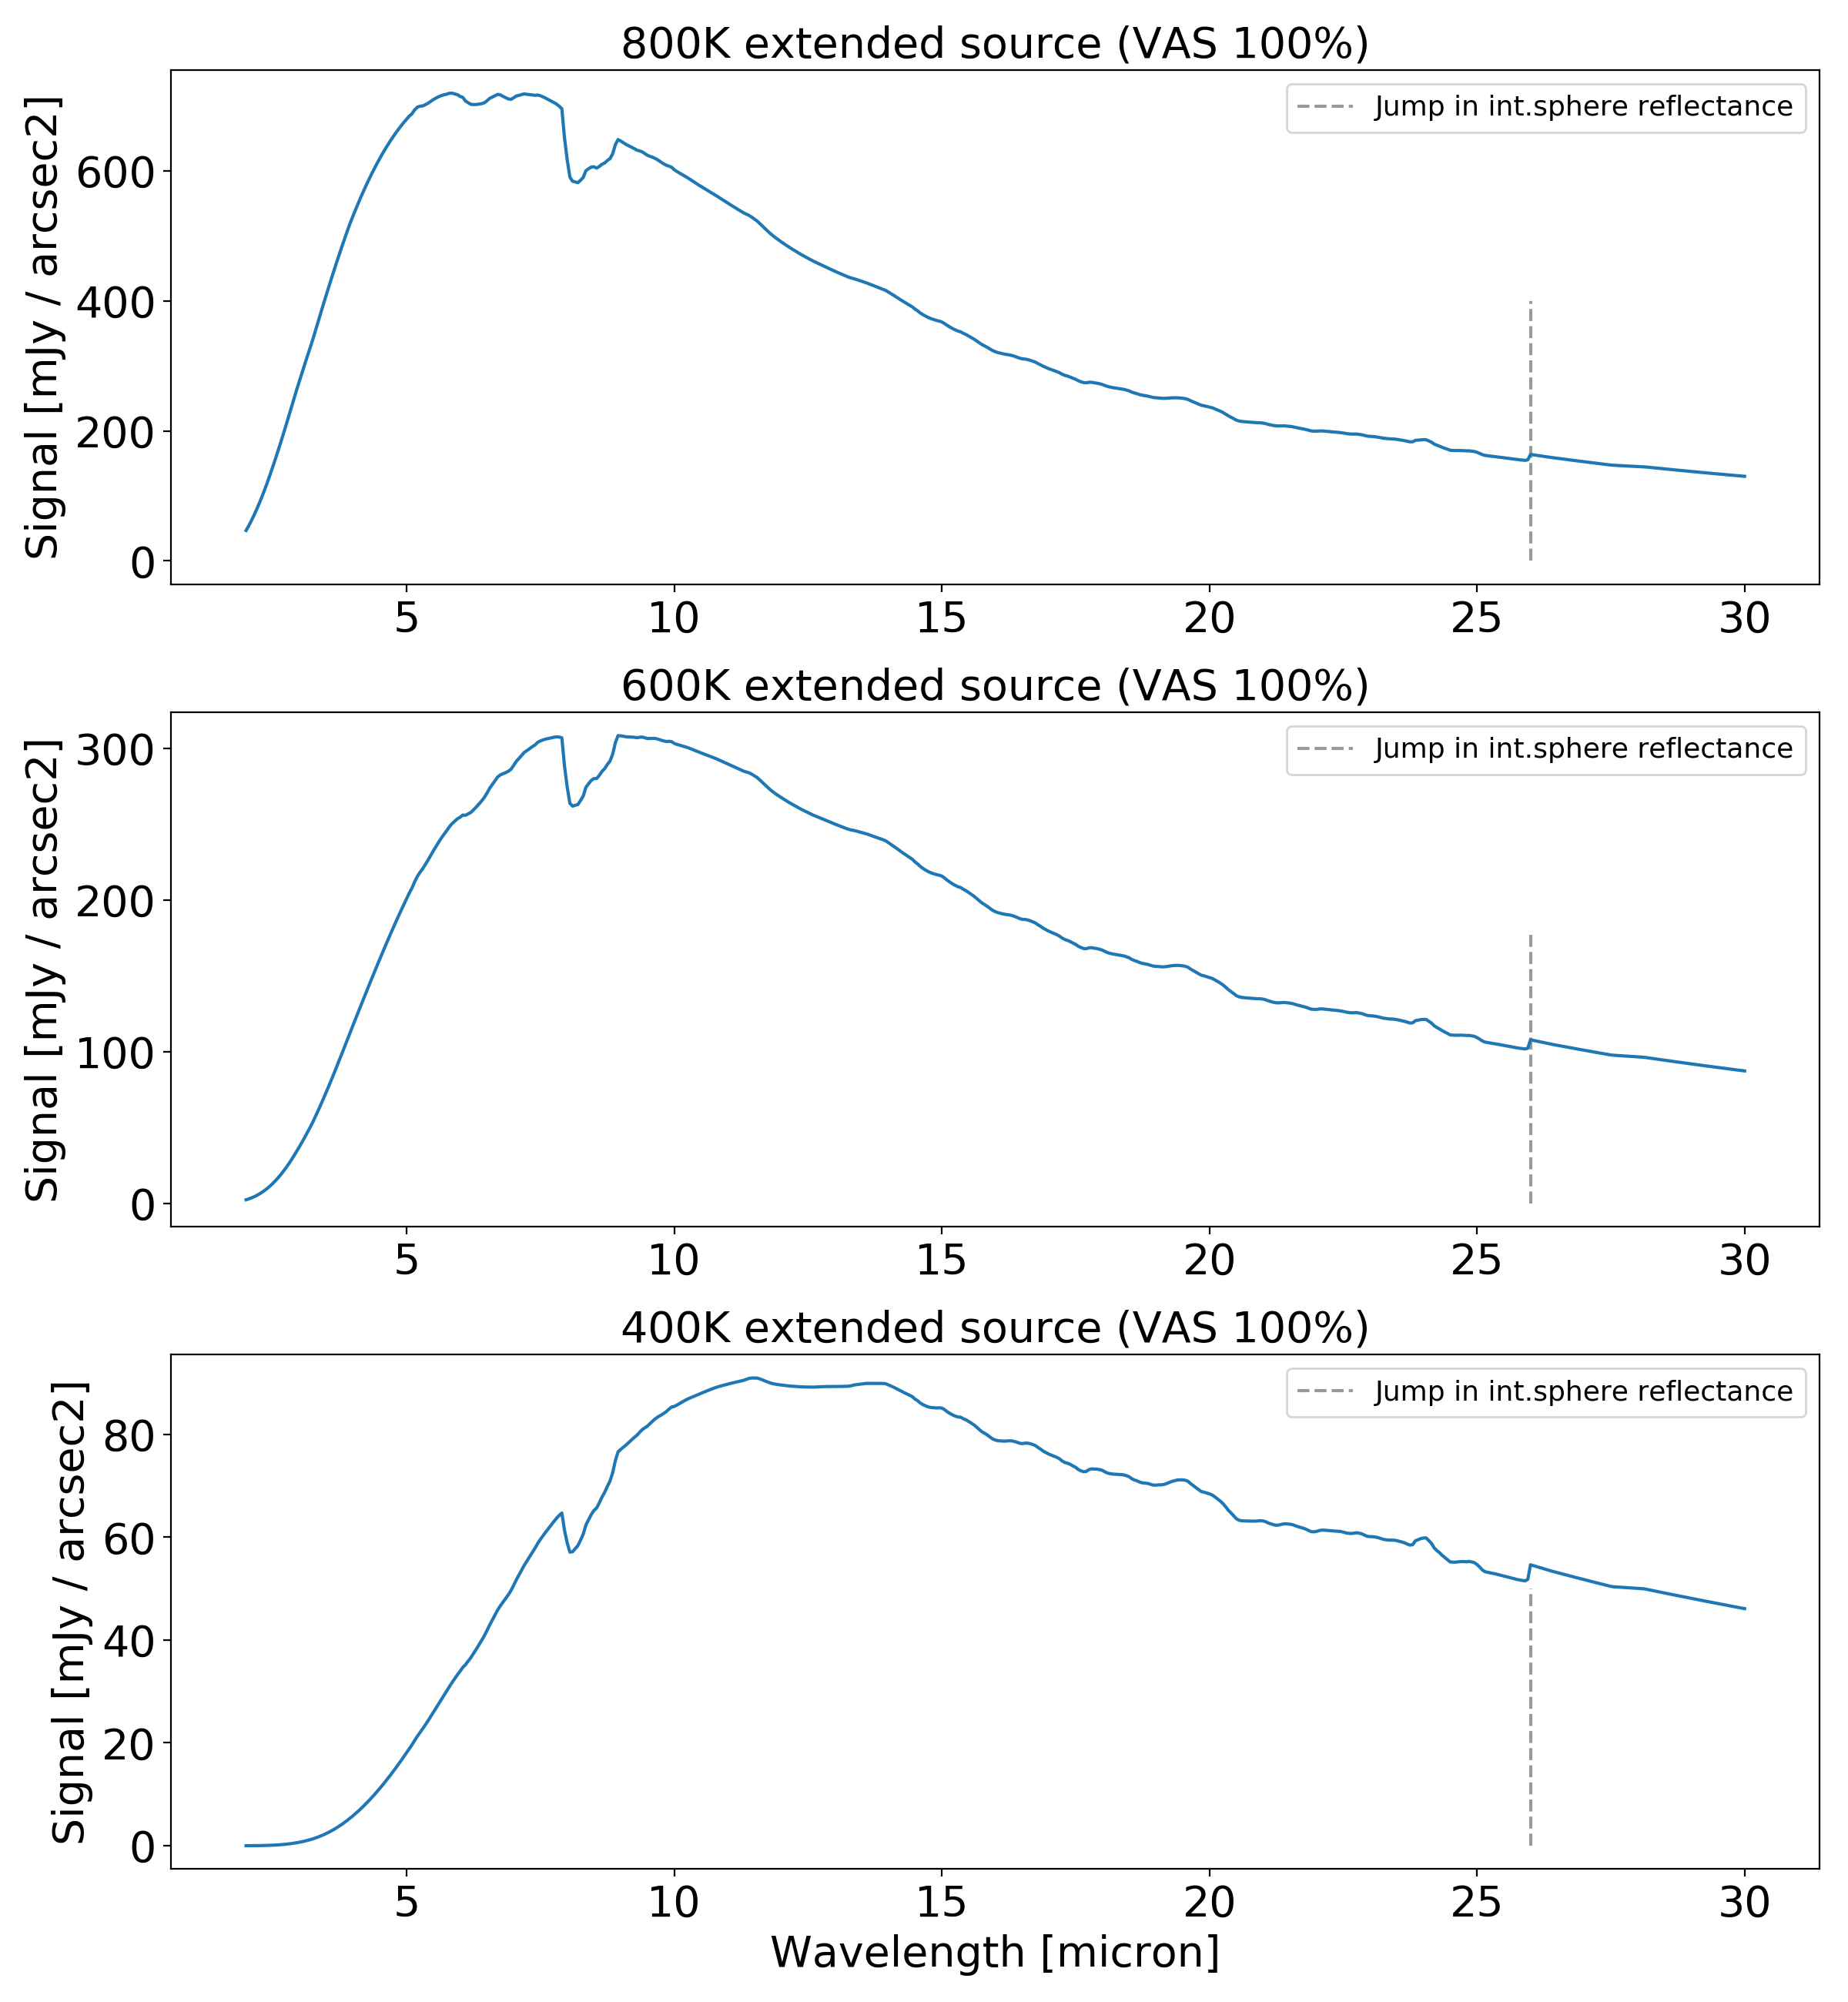

In [5]:
# make some comparative plots
import matplotlib.pyplot as plt
%matplotlib notebook

max_signal = [400,180,50]
fig,axs = plt.subplots(3,1,figsize=(12,13))
for plot,BB_Temp in enumerate(['800K','600K','400K']):
    axs[plot].set_title('{} extended source (VAS 100%)'.format(BB_Temp),fontsize=20)
    axs[plot].plot(waves[BB_Temp[:3]],L_skys[BB_Temp[:3]]*1000.)
    axs[plot].vlines(26,0,max_signal[plot],linestyle='dashed',alpha=0.4,label='Jump in int.sphere reflectance')
    axs[plot].set_ylabel('Signal [mJy / arcsec2]',fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=13)
    axs[plot].tick_params(axis='both',labelsize=20)
axs[2].set_xlabel('Wavelength [micron]',fontsize=20)
plt.tight_layout()

max_signal = [400,180,50]
fig,axs = plt.subplots(3,1,figsize=(12,13))
for plot,BB_Temp in enumerate(['800K','600K','400K']):
    axs[plot].set_title('{} extended source (VAS 100%)'.format(BB_Temp),fontsize=20)
    axs[plot].plot(waves[BB_Temp[:3]],L_skys[BB_Temp[:3]]*1000.)
    axs[plot].vlines(26,0,max_signal[plot],linestyle='dashed',alpha=0.4,label='Jump in int.sphere reflectance')
    axs[plot].set_ylabel('Signal [mJy / arcsec2]',fontsize=20)
    axs[plot].legend(loc='upper right',fontsize=13)
    axs[plot].tick_params(axis='both',labelsize=20)
axs[2].set_xlabel('Wavelength [micron]',fontsize=20)
plt.tight_layout()